In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import entropy  # Add import for entropy function
from environments import SBEOS_Environment

# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a transition tuple for experience replay
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayBuffer:
    """Standard Experience Replay Buffer"""
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        """Save a transition to the replay buffer"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Sample a batch of transitions"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    """Deep Q-Network"""
    def __init__(self, state_size, action_size, hidden_size=128):  # Larger network
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)  # Add batch normalization
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)  # Add batch normalization
        self.fc3 = nn.Linear(hidden_size, action_size)
        
        # Initialize weights with smaller values
        nn.init.xavier_uniform_(self.fc1.weight, gain=0.1)
        nn.init.xavier_uniform_(self.fc2.weight, gain=0.1)
        nn.init.xavier_uniform_(self.fc3.weight, gain=0.1)

    def forward(self, x):
        # Apply batch norm only during training with batch size > 1
        if x.size(0) > 1:
            x = F.leaky_relu(self.bn1(self.fc1(x)))  # Leaky ReLU for better gradients
            x = F.leaky_relu(self.bn2(self.fc2(x)))
        else:
            x = F.leaky_relu(self.fc1(x))
            x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)

class DoubleDQNAgent:
    def __init__(
        self,
        state_size,
        action_size,
        memory_size=10000,
        batch_size=64,
        gamma=0.99,
        learning_rate=0.0003,  # Reduced learning rate for stability
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=5000,    # Faster exploration decay
        target_update_freq=5   # More frequent target updates
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq
        self.steps_done = 0
        self.episode_count = 0

        # Initialize replay memory
        self.memory = ReplayBuffer(memory_size)

        # Initialize Q-networks
        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        
        # Initialize target network with policy network weights
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # Set target network to evaluation mode
        
        # Initialize optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        
        # Training metrics
        self.rewards_history = []
        self.losses = []

    def select_action(self, state, evaluate=False):
        """Select an action using epsilon-greedy policy"""
        if not evaluate and random.random() < self.epsilon:
            # Random action
            return random.randrange(self.action_size)
        
        # Convert state to tensor
        with torch.no_grad():
            if isinstance(state, np.ndarray):
                state_tensor = torch.FloatTensor(state).to(device)
            else:
                state_tensor = torch.FloatTensor([state]).to(device)
                
            # Make sure it has batch dimension
            if state_tensor.dim() == 1:
                state_tensor = state_tensor.unsqueeze(0)
            
            # Get Q-values and choose the best action
            q_values = self.policy_net(state_tensor)
            return q_values.argmax(1).item()
    
    def update_epsilon(self):
        """Update epsilon using exponential decay"""
        self.epsilon = self.epsilon_end + (self.epsilon - self.epsilon_end) * \
                       np.exp(-1. * self.steps_done / self.epsilon_decay)
        self.steps_done += 1
    
    def remember(self, state, action, reward, next_state, done):
        """Store transition in replay memory"""
        self.memory.push(state, action, next_state, reward, done)
    
    def replay(self):
        """Train the model with experiences from replay buffer"""
        if len(self.memory) < self.batch_size:
            return 0
        
        # Sample batch from replay buffer
        transitions = self.memory.sample(self.batch_size)
        
        # Convert batch to tensors (unpack the batch)
        batch = Transition(*zip(*transitions))
        
        # Preprocess and normalize input data
        states_array = np.array(batch.state)
        next_states_array = np.array(batch.next_state)
        
        # Normalize the states for better training stability
        states_mean = np.mean(states_array, axis=0, keepdims=True)
        states_std = np.std(states_array, axis=0, keepdims=True) + 1e-5
        states_array = (states_array - states_mean) / states_std
        next_states_array = (next_states_array - states_mean) / states_std
        
        state_batch = torch.FloatTensor(states_array).to(device)
        action_batch = torch.LongTensor(batch.action).unsqueeze(1).to(device)
        reward_batch = torch.FloatTensor(batch.reward).unsqueeze(1).to(device)
        next_state_batch = torch.FloatTensor(next_states_array).to(device)
        done_batch = torch.FloatTensor(batch.done).unsqueeze(1).to(device)
        
        # Clip rewards for stability
        reward_batch = torch.clamp(reward_batch, -10, 10)
        
        # Compute current Q values
        current_q_values = self.policy_net(state_batch).gather(1, action_batch)
        
        # Compute next Q values using Double DQN approach
        with torch.no_grad():
            # Use online network to SELECT actions
            next_actions = self.policy_net(next_state_batch).max(1, keepdim=True)[1]
            # Use target network to EVALUATE actions
            next_q_values = self.target_net(next_state_batch).gather(1, next_actions)
            # Apply reward clipping and scale target values
            expected_q_values = reward_batch + self.gamma * next_q_values * (1 - done_batch)
            
            # Apply target clipping to prevent outliers
            expected_q_values = torch.clamp(expected_q_values, -15, 15)
        
        # Compute loss (Huber loss for stability)
        loss = F.smooth_l1_loss(current_q_values, expected_q_values)
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients (reduced threshold)
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 0.5)
        self.optimizer.step()
        
        return loss.item()
    
    def update_target_network(self):
        """Hard update of the target network weights"""
        # Increment episode counter
        self.episode_count += 1
        
        if self.episode_count % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def save_model(self, filepath):
        """Save model weights"""
        torch.save({
            'policy_net': self.policy_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'steps_done': self.steps_done
        }, filepath)
        
    def load_model(self, filepath):
        """Load model weights"""
        checkpoint = torch.load(filepath)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']
        self.steps_done = checkpoint['steps_done']
        self.target_net.eval()

def train_double_dqn(env, agent, episodes=200, max_steps=1000, warmup_steps=1000):
    """Train the Double DQN agent with improvements for stability"""
    all_rewards = []  # Track rewards for early stopping
    best_avg_reward = -float('inf')
    patience = 30  # Episodes to wait before early stopping
    patience_counter = 0
    
    # Fill replay buffer with random transitions before training (warmup)
    print("Filling replay buffer with random experience...")
    state = env.reset()
    for _ in tqdm(range(warmup_steps)):
        action = random.randrange(agent.action_size)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            state = env.reset()
    
    print("Starting training...")
    for episode in tqdm(range(episodes), desc="Training Double DQN"):
        state = env.reset()
        episode_reward = 0
        episode_loss = 0
        step_count = 0
        
        for step in range(max_steps):
            step_count = step + 1
            
            # Select action
            action = agent.select_action(state)
            
            # Execute action
            next_state, reward, done, _ = env.step(action)
            
            # Store transition in replay buffer
            agent.remember(state, action, reward, next_state, done)
            
            # Update state
            state = next_state
            episode_reward += reward
            
            # Train the agent - multiple updates per step for better learning
            num_updates = 1
            total_step_loss = 0
            for _ in range(num_updates):
                loss = agent.replay()
                if loss is not None:
                    total_step_loss += loss
            
            episode_loss += total_step_loss / num_updates
            
            # Update epsilon for exploration
            agent.update_epsilon()
            
            if done:
                break
        
        # Update target network
        agent.update_target_network()
        
        # Record episode metrics
        agent.rewards_history.append(episode_reward)
        if step_count > 0:
            agent.losses.append(episode_loss / step_count)
        else:
            agent.losses.append(0)
        
        # Track for early stopping
        all_rewards.append(episode_reward)
        
        # Calculate running average of last 20 episodes
        if len(all_rewards) >= 20:
            current_avg = np.mean(all_rewards[-20:])
            
            # Check if we have a new best average reward
            if current_avg > best_avg_reward:
                best_avg_reward = current_avg
                patience_counter = 0
                
                # Save the best model
                if episode > 50:  # Only save after some training
                    agent.save_model("best_double_dqn_model.pt")
            else:
                patience_counter += 1
            
            # Check for early stopping
            if patience_counter >= patience and episode > 50:
                print(f"Early stopping at episode {episode+1} due to no improvement")
                break
        
        # Print progress
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(agent.rewards_history[-10:])
            print(f"Episode: {episode+1}, Reward: {episode_reward:.2f}, Avg Reward (last 10): {avg_reward:.2f}, "
                  f"Loss: {agent.losses[-1]:.6f}, Epsilon: {agent.epsilon:.4f}")
    
    # Load the best model if we saved one
    try:
        agent.load_model("best_double_dqn_model.pt")
        print("Loaded best model from training")
    except:
        print("Using final model (no best model found)")
    
    return agent

def evaluate_agent(env, agent, episodes=10):
    """Evaluate the agent without exploration"""
    eval_rewards = []
    
    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            # Select action without exploration
            action = agent.select_action(state, evaluate=True)
            
            # Execute action
            next_state, reward, done, _ = env.step(action)
            
            # Update state and reward
            state = next_state
            episode_reward += reward
        
        eval_rewards.append(episode_reward)
    
    avg_reward = np.mean(eval_rewards)
    print(f"Evaluation - Average reward over {episodes} episodes: {avg_reward:.2f}")
    return avg_reward

def plot_results(rewards, losses):
    """Plot training metrics"""
    plt.figure(figsize=(12, 5))
    
    # Plot rewards
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.plot(np.convolve(rewards, np.ones(10)/10, mode='valid'), 'r-')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards')
    plt.grid(True)
    
    # Plot losses
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# if __name__ == "__main__":
#     # Create environment
#     env = SBEOS_Environment(window_size=10, max_timesteps=100)
    
#     # Get the state size from the environment's observation space
#     initial_observation = env.reset()
#     state_size = len(initial_observation)
#     print(f"State size: {state_size}")
    
#     # Create agent with the correct state size and improved hyperparameters
#     agent = DoubleDQNAgent(
#         state_size=state_size,  # Use the detected state size
#         action_size=2,          # Binary action space (0 or 1)
#         memory_size=50000,      # Larger memory for better stability
#         batch_size=32,          # Smaller batch size
#         gamma=0.95,             # Slightly lower discount factor
#         learning_rate=0.0001,   # Lower learning rate for stability
#         epsilon_start=1.0,
#         epsilon_end=0.05,       # Slightly higher end exploration
#         epsilon_decay=5000,     # Faster exploration decay
#         target_update_freq=5    # More frequent target updates
#     )
    
#     # Train agent with improved parameters
#     trained_agent = train_double_dqn(
#         env, 
#         agent, 
#         episodes=300,       # More episodes for better learning
#         max_steps=100,
#         warmup_steps=2000   # Pre-fill replay buffer
#     )
    
#     # Evaluate agent
#     avg_reward = evaluate_agent(env, trained_agent, episodes=30)
    
#     # Plot results
#     plot_results(agent.rewards_history, agent.losses)
    
#     # Save the final trained model
#     agent.save_model("final_double_dqn_model.pt")

State size: 16
Filling replay buffer with random experience...


100%|██████████| 2000/2000 [00:00<00:00, 2964.76it/s]


Starting training...


Training Double DQN:   3%|▎         | 10/300 [00:03<01:27,  3.31it/s]

Episode: 10, Reward: 840.00, Avg Reward (last 10): 717.00, Loss: 4.154980, Epsilon: 0.0500


Training Double DQN:   7%|▋         | 20/300 [00:06<01:20,  3.47it/s]

Episode: 20, Reward: 775.00, Avg Reward (last 10): 709.00, Loss: 1.871294, Epsilon: 0.0500


Training Double DQN:  10%|█         | 30/300 [00:08<01:16,  3.52it/s]

Episode: 30, Reward: 885.00, Avg Reward (last 10): 777.50, Loss: 0.358684, Epsilon: 0.0500


Training Double DQN:  13%|█▎        | 40/300 [00:11<01:16,  3.39it/s]

Episode: 40, Reward: 960.00, Avg Reward (last 10): 975.50, Loss: 0.200962, Epsilon: 0.0500


Training Double DQN:  17%|█▋        | 50/300 [00:14<01:15,  3.30it/s]

Episode: 50, Reward: 745.00, Avg Reward (last 10): 930.00, Loss: 0.137971, Epsilon: 0.0500


Training Double DQN:  20%|██        | 60/300 [00:17<01:09,  3.46it/s]

Episode: 60, Reward: 710.00, Avg Reward (last 10): 743.00, Loss: 0.122062, Epsilon: 0.0500


Training Double DQN:  23%|██▎       | 70/300 [00:20<01:07,  3.41it/s]

Episode: 70, Reward: 855.00, Avg Reward (last 10): 769.50, Loss: 0.100007, Epsilon: 0.0500


Training Double DQN:  26%|██▌       | 78/300 [00:23<01:06,  3.35it/s]

Early stopping at episode 79 due to no improvement
Using final model (no best model found)



/tmp/ipykernel_11903/1921539810.py:220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)
/home/ayush/Ayush/EE_Spectrum_Hole_Detection_with_RL

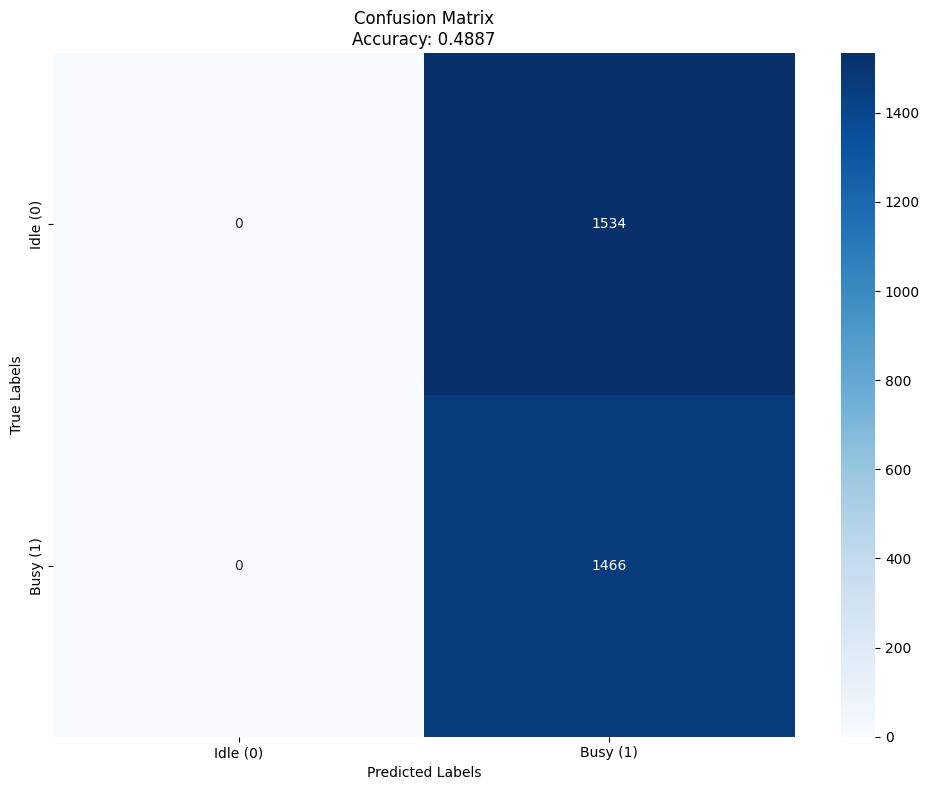

Classification Report:
              precision    recall  f1-score   support

    Idle (0)       0.00      0.00      0.00      1534
    Busy (1)       0.49      1.00      0.66      1466

    accuracy                           0.49      3000
   macro avg       0.24      0.50      0.33      3000
weighted avg       0.24      0.49      0.32      3000

Evaluation - Average reward over 30 episodes: 744.33


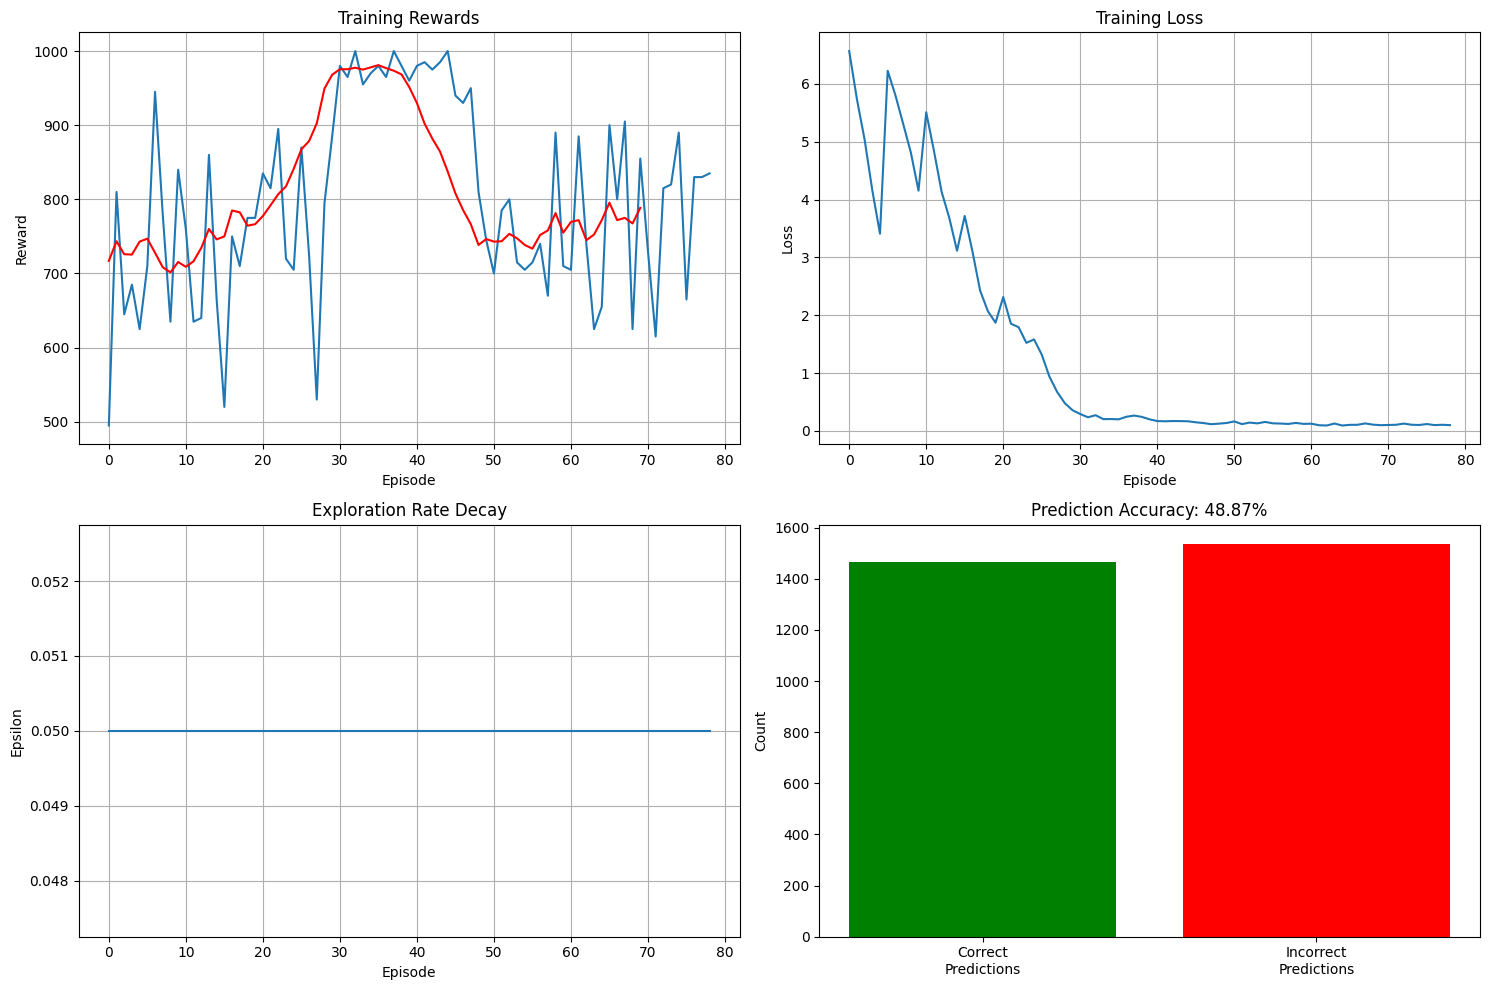

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_agent_with_confusion_matrix(env, agent, episodes=30):
    """
    Evaluate the agent and generate a confusion matrix
    """
    true_states = []
    predicted_states = []
    eval_rewards = []
    
    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            # Select action without exploration
            action = agent.select_action(state, evaluate=True)
            
            # Record the prediction and true state
            predicted_states.append(action)
            true_states.append(env.actual_current_state)
            
            # Execute action
            next_state, reward, done, _ = env.step(action)
            
            # Update state and reward
            state = next_state
            episode_reward += reward
        
        eval_rewards.append(episode_reward)
    
    # Calculate and plot confusion matrix
    cm = confusion_matrix(true_states, predicted_states)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    
    # Generate classification report
    target_names = ['Idle (0)', 'Busy (1)']
    report = classification_report(true_states, predicted_states, target_names=target_names)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, 
                yticklabels=target_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.4f}')
    plt.tight_layout()
    plt.show()
    
    print("Classification Report:")
    print(report)
    
    avg_reward = np.mean(eval_rewards)
    print(f"Evaluation - Average reward over {episodes} episodes: {avg_reward:.2f}")
    
    return cm, accuracy, avg_reward

def plot_comprehensive_results(agent, confusion_matrix, accuracy):
    """
    Plot comprehensive training metrics including confusion matrix stats
    """
    plt.figure(figsize=(15, 10))
    
    # Plot rewards
    plt.subplot(2, 2, 1)
    plt.plot(agent.rewards_history)
    plt.plot(np.convolve(agent.rewards_history, np.ones(10)/10, mode='valid'), 'r-')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards')
    plt.grid(True)
    
    # Plot losses
    plt.subplot(2, 2, 2)
    plt.plot(agent.losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    
    # Plot epsilon decay
    plt.subplot(2, 2, 3)
    episodes = len(agent.rewards_history)
    epsilons = [agent.epsilon_end + (agent.epsilon - agent.epsilon_end) * 
                np.exp(-1. * i / agent.epsilon_decay) for i in range(episodes)]
    plt.plot(epsilons)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Exploration Rate Decay')
    plt.grid(True)
    
    # Plot prediction accuracy
    plt.subplot(2, 2, 4)
    labels = ['Correct\nPredictions', 'Incorrect\nPredictions']
    correct = confusion_matrix[0, 0] + confusion_matrix[1, 1]
    incorrect = confusion_matrix[0, 1] + confusion_matrix[1, 0]
    values = [correct, incorrect]
    plt.bar(labels, values, color=['green', 'red'])
    plt.ylabel('Count')
    plt.title(f'Prediction Accuracy: {accuracy:.2%}')
    
    plt.tight_layout()
    plt.show()


# Update the main function to include confusion matrix evaluation
if __name__ == "__main__":
    # Create environment
    env = SBEOS_Environment(window_size=20, max_timesteps=100)
    
    # Get the state size from the environment's observation space
    initial_observation = env.reset()
    state_size = len(initial_observation)
    print(f"State size: {state_size}")
    
    # Create agent with the correct state size and improved hyperparameters
    agent = DoubleDQNAgent(
        state_size=state_size,  # Use the detected state size
        action_size=2,          # Binary action space (0 or 1)
        memory_size=50000,      # Larger memory for better stability
        batch_size=32,          # Smaller batch size
        gamma=0.95,             # Slightly lower discount factor
        learning_rate=0.0001,   # Lower learning rate for stability
        epsilon_start=1.0,
        epsilon_end=0.05,       # Slightly higher end exploration
        epsilon_decay=5000,     # Faster exploration decay
        target_update_freq=5    # More frequent target updates
    )
    
    # Train agent with improved parameters
    trained_agent = train_double_dqn(
        env, 
        agent, 
        episodes=300,       # More episodes for better learning
        max_steps=100,
        warmup_steps=2000   # Pre-fill replay buffer
    )
    
    # Evaluate agent with confusion matrix
    cm, accuracy, avg_reward = evaluate_agent_with_confusion_matrix(env, trained_agent, episodes=30)
    
    # Plot comprehensive results
    plot_comprehensive_results(trained_agent, cm, accuracy)
    
    # Save the final trained model
    agent.save_model("final_double_dqn_model.pt")